<a href="https://www.kaggle.com/code/ravaghi/titanic-survival-prediction-with-ensemble-modeling?scriptVersionId=167023081" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import ensemble, gaussian_process, linear_model, naive_bayes, neighbors, svm, tree, discriminant_analysis
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, learning_curve
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

plt.style.use("ggplot")
warnings.filterwarnings('ignore')
seed = 27

# Loading Data

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

train_data_copy = train_data.copy()

passenger_ids = test_data["PassengerId"]

In [3]:
def get_metadata(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "dtype": df.dtypes,
        "n_missing": df.isna().sum(),
        "n_unique": df.nunique()},
        index=df.columns
    )

In [4]:
get_metadata(train_data)

,dtype,n_missing,n_unique
PassengerId,int64,0,891
Survived,int64,0,2
Pclass,int64,0,3
Name,object,0,891
Sex,object,0,2
Age,float64,177,88
SibSp,int64,0,7
Parch,int64,0,7
Ticket,object,0,681
Fare,float64,0,248


In [5]:
get_metadata(test_data)

,dtype,n_missing,n_unique
PassengerId,int64,0,418
Pclass,int64,0,3
Name,object,0,418
Sex,object,0,2
Age,float64,86,79
SibSp,int64,0,7
Parch,int64,0,8
Ticket,object,0,363
Fare,float64,1,169
Cabin,object,327,76


# Handling Missing Values

In [6]:
def fill_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    return df

train_data_copy = fill_missing_values(train_data_copy)
train_data = fill_missing_values(train_data)
test_data = fill_missing_values(test_data)

In [7]:
get_metadata(train_data)

,dtype,n_missing,n_unique
PassengerId,int64,0,891
Survived,int64,0,2
Pclass,int64,0,3
Name,object,0,891
Sex,object,0,2
Age,float64,0,88
SibSp,int64,0,7
Parch,int64,0,7
Ticket,object,0,681
Fare,float64,0,248


In [8]:
get_metadata(test_data)

,dtype,n_missing,n_unique
PassengerId,int64,0,418
Pclass,int64,0,3
Name,object,0,418
Sex,object,0,2
Age,float64,0,79
SibSp,int64,0,7
Parch,int64,0,8
Ticket,object,0,363
Fare,float64,0,169
Cabin,object,327,76


# Adding and Dropping Features

In [9]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['Title'] = df['Name'].apply(lambda x: re.search(' ([A-Za-z]+)\.', x).group(1))
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['FareBin'] = pd.qcut(df['Fare'], 4)
    df['AgeBin'] = pd.cut(df['Age'].astype(int), 5)
    return df

train_data_copy = add_features(train_data_copy)
train_data = add_features(train_data)
test_data = add_features(test_data)

In [10]:
encoder = LabelEncoder()
def encode_features(df: pd.DataFrame) -> pd.DataFrame:
    df["Sex"] = encoder.fit_transform(df["Sex"])
    df["Embarked"] = encoder.fit_transform(df["Embarked"])
    df["Title"] = encoder.fit_transform(df["Title"])
    df["AgeBin"] = encoder.fit_transform(df["AgeBin"])
    df["FareBin"] = encoder.fit_transform(df["FareBin"])
    return df

train_data_copy = encode_features(train_data_copy)
train_data = encode_features(train_data)
test_data = encode_features(test_data)

In [11]:
def drop_features(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(columns=[
        'PassengerId', 'Ticket', 'Cabin', 'Name', 'Age', 'Fare'
    ])
    
train_data = drop_features(train_data)
test_data = drop_features(test_data)

In [12]:
get_metadata(train_data)

,dtype,n_missing,n_unique
Survived,int64,0,2
Pclass,int64,0,3
Sex,int64,0,2
SibSp,int64,0,7
Parch,int64,0,7
Embarked,int64,0,3
FamilySize,int64,0,9
IsAlone,int64,0,2
Title,int64,0,5
FareBin,int64,0,4


In [13]:
get_metadata(test_data)

,dtype,n_missing,n_unique
Pclass,int64,0,3
Sex,int64,0,2
SibSp,int64,0,7
Parch,int64,0,8
Embarked,int64,0,3
FamilySize,int64,0,9
IsAlone,int64,0,2
Title,int64,0,5
FareBin,int64,0,4
AgeBin,int64,0,5


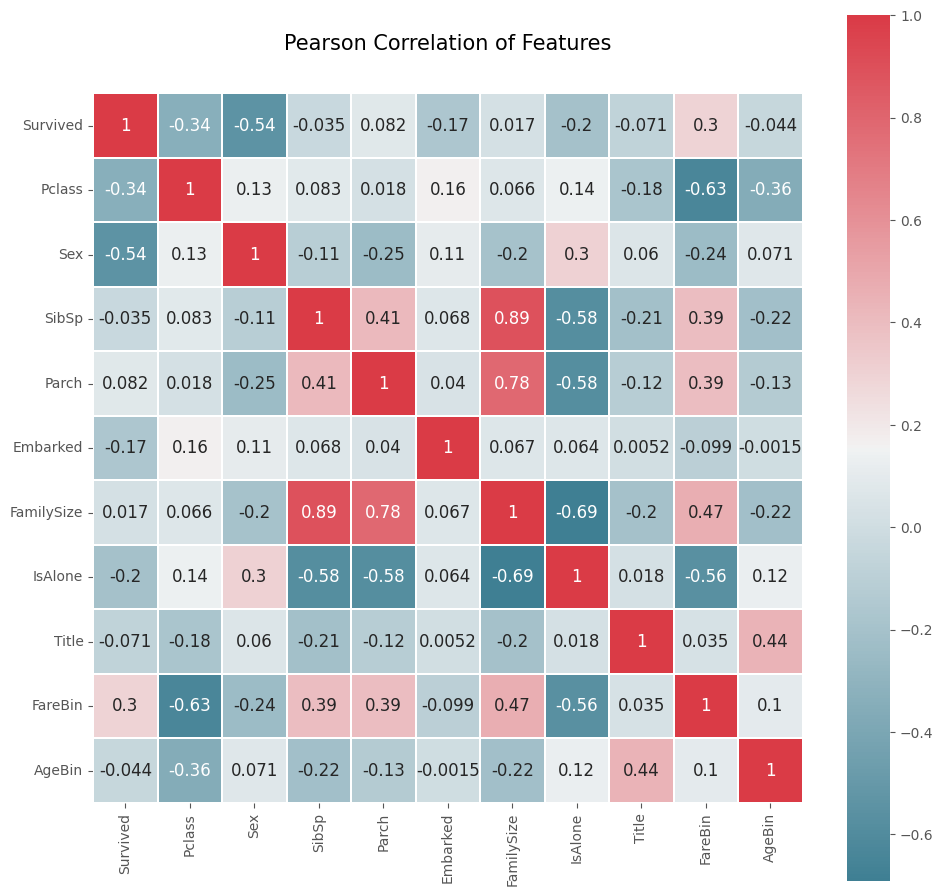

In [14]:
_, ax = plt.subplots(figsize=(10, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(
    train_data.corr(),
    cmap=colormap,
    square=True,
    cbar_kws={"shrink": .9},
    ax=ax,
    annot=True,
    linewidths=0.1, vmax=1.0, linecolor="white",
    annot_kws={"fontsize": 12}
)

plt.title("Pearson Correlation of Features", y=1.05, size=15)
plt.tight_layout()
plt.show()

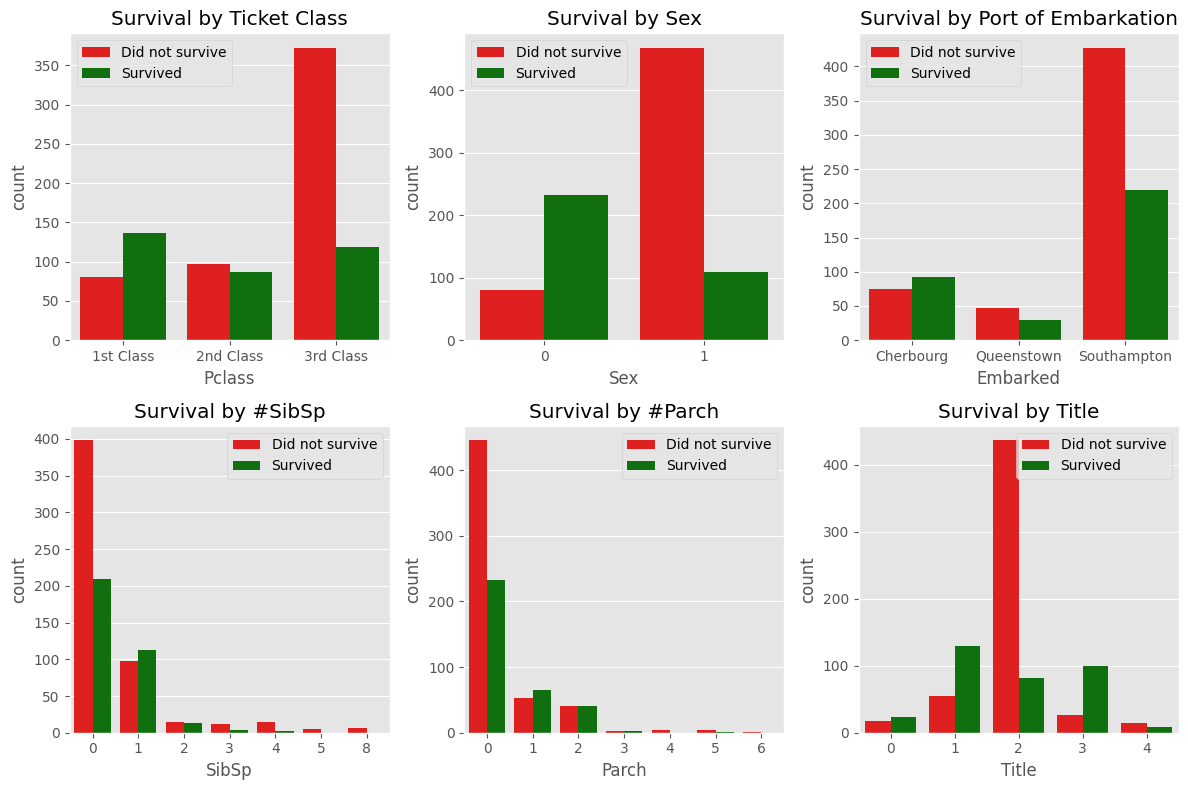

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

sns.countplot(x='Pclass', hue='Survived', data=train_data_copy, palette={0: 'red', 1: 'green'}, ax=ax[0, 0])
ax[0, 0].set_title('Survival by Ticket Class')
ax[0, 0].set_xticks([0, 1, 2])
ax[0, 0].set_xticklabels(['1st Class', '2nd Class', '3rd Class'])
ax[0, 0].legend(labels=["Did not survive", "Survived"])

sns.countplot(x='Sex', hue='Survived', data=train_data_copy, palette={0: 'red', 1: 'green'}, ax=ax[0, 1])
ax[0, 1].set_title('Survival by Sex')
ax[0, 1].legend(labels=["Did not survive", "Survived"])

sns.countplot(x='Embarked', hue='Survived', data=train_data_copy, palette={0: 'red', 1: 'green'}, ax=ax[0, 2])
ax[0, 2].set_title('Survival by Port of Embarkation')
ax[0, 2].set_xticks([0, 1, 2])
ax[0, 2].set_xticklabels(["Cherbourg", "Queenstown", "Southampton"])
ax[0, 2].legend(labels=["Did not survive", "Survived"])

sns.countplot(x='SibSp', hue='Survived', data=train_data_copy, palette={0: 'red', 1: 'green'}, ax=ax[1, 0])
ax[1, 0].set_title('Survival by #SibSp')
ax[1, 0].legend(labels=["Did not survive", "Survived"])

sns.countplot(x='Parch', hue='Survived', data=train_data_copy, palette={0: 'red', 1: 'green'}, ax=ax[1, 1])
ax[1, 1].set_title('Survival by #Parch')
ax[1, 1].legend(labels=["Did not survive", "Survived"])

sns.countplot(x='Title', hue='Survived', data=train_data_copy, palette={0: 'red', 1: 'green'}, ax=ax[1, 2])
ax[1, 2].set_title('Survival by Title')
ax[1, 2].legend(labels=["Did not survive", "Survived"])

plt.tight_layout()
plt.show()

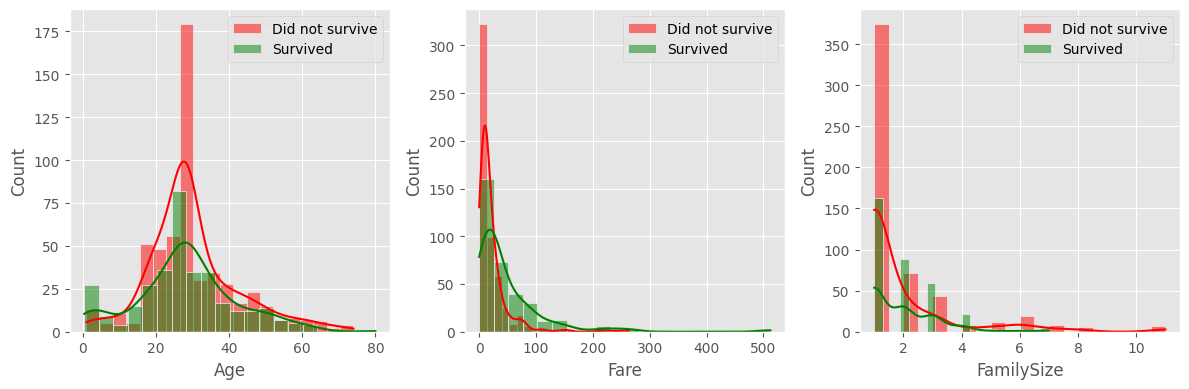

In [16]:
survivors = train_data_copy[train_data_copy['Survived'] == 1]
non_survivors = train_data_copy[train_data_copy['Survived'] == 0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, column_name in enumerate(["Age", "Fare", "FamilySize"]):
    sns.histplot(non_survivors[column_name], bins=20, color='red', label='Did not survive', ax=ax[i], kde=True)
    sns.histplot(survivors[column_name], bins=20, color='green', label='Survived', ax=ax[i], kde=True)
    ax[i].set_xlabel(column_name)
    ax[i].set_ylabel('Count')
    ax[i].legend()

plt.tight_layout()
plt.show()

In [17]:
X = train_data.drop("Survived", axis=1)
y = train_data["Survived"]

X_scaled = MinMaxScaler().fit_transform(X)

k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# Selecting Models for the Ensemble

In [18]:
models = [
    XGBClassifier(random_state=seed),
    CatBoostClassifier(random_state=seed, verbose=False),
    LGBMClassifier(verbose=-100, random_state=seed),
    ensemble.AdaBoostClassifier(random_state=seed),
    ensemble.BaggingClassifier(random_state=seed),
    ensemble.ExtraTreesClassifier(random_state=seed),
    ensemble.GradientBoostingClassifier(verbose=False, random_state=seed),
    ensemble.RandomForestClassifier(random_state=seed),
    gaussian_process.GaussianProcessClassifier(random_state=seed),
    linear_model.LogisticRegressionCV(random_state=seed),
    linear_model.PassiveAggressiveClassifier(random_state=seed),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(random_state=seed),
    linear_model.Perceptron(random_state=seed),
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    neighbors.KNeighborsClassifier(),
    svm.SVC(probability=True, random_state=seed),
    svm.NuSVC(probability=True, random_state=seed),
    svm.LinearSVC(random_state=seed),
    tree.DecisionTreeClassifier(random_state=seed),
    tree.ExtraTreeClassifier(random_state=seed),
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis()
]

In [19]:
model_results = pd.DataFrame(
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"]
)
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

for model in models:
    results = cross_validate(
        estimator=model,
        X=X_scaled,
        y=y, cv=k_fold,
        scoring=scoring,
        n_jobs=-1,
        verbose=0
    )
    model_result = pd.DataFrame({
        "Model": [model.__class__.__name__],
        "Accuracy": [results["test_accuracy"].mean()],
        "Precision": [results["test_precision"].mean()],
        "Recall": [results["test_recall"].mean()],
        "F1": [results["test_f1"].mean()],
        "AUC": [results["test_roc_auc"].mean()]
    })
    model_results = pd.concat([model_results, model_result])

/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.10/site-packages/sklearn/disc

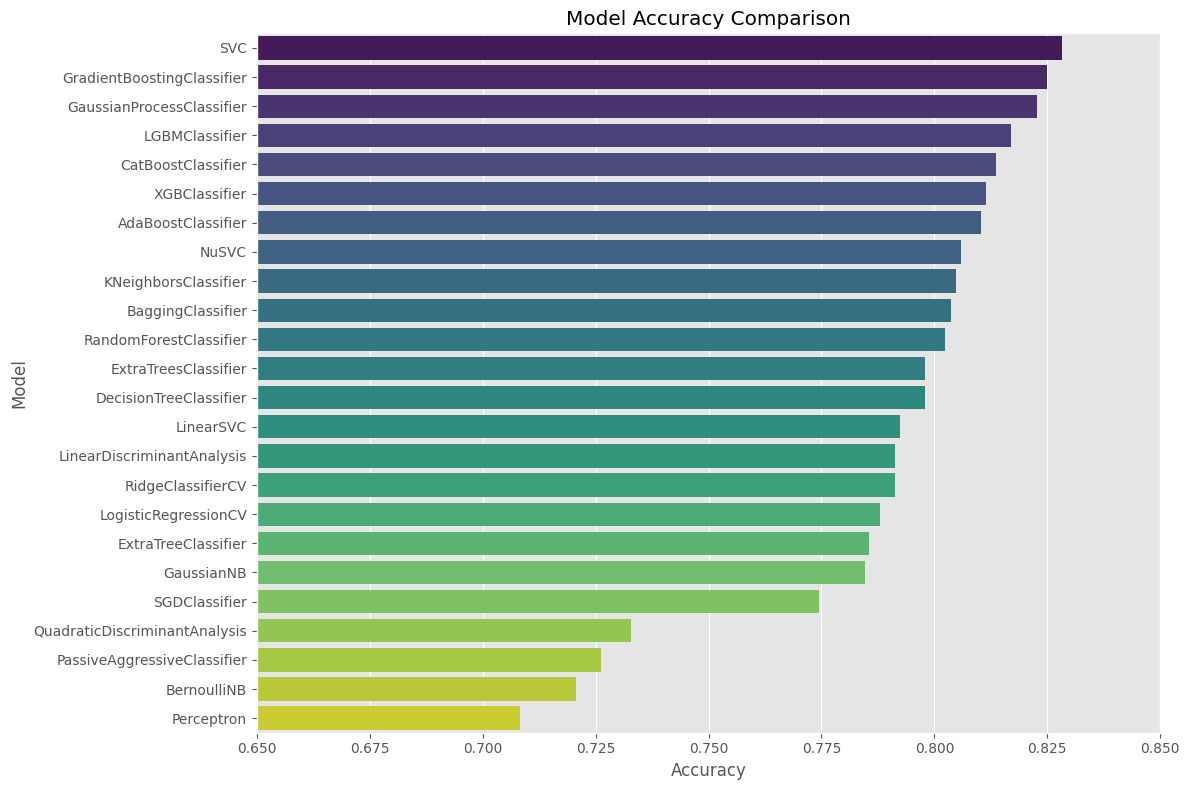

In [20]:
model_results = model_results.sort_values(by="Accuracy", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=model_results, x="Accuracy", y="Model", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlim(0.65, 0.85)
plt.tight_layout()
plt.show()

In [21]:
model_results.reset_index(drop=True).style.background_gradient()

,Model,Accuracy,Precision,Recall,F1,AUC
0,SVC,0.828302,0.824317,0.707731,0.760700,0.848662
1,GradientBoostingClassifier,0.824894,0.829511,0.690168,0.751574,0.866664
2,GaussianProcessClassifier,0.822709,0.820943,0.693361,0.749988,0.864435
3,LGBMClassifier,0.817054,0.796399,0.710588,0.749517,0.869419
4,CatBoostClassifier,0.813683,0.791835,0.707647,0.745564,0.868171
5,XGBClassifier,0.811423,0.786659,0.704874,0.741679,0.853828
6,AdaBoostClassifier,0.810350,0.763957,0.742857,0.751661,0.862919
7,NuSVC,0.805868,0.796846,0.672941,0.726448,0.848713
8,KNeighborsClassifier,0.804744,0.781285,0.693025,0.732608,0.839813
9,BaggingClassifier,0.803571,0.759047,0.721933,0.737231,0.855474


# Tuning Top 5 Models

In [22]:
svc_model = svm.SVC(probability=True, random_state=seed)

svc_param_grid = {
    "C": [1, 2, 5, 10, 50, 100],
    "kernel": ["rbf", "poly"],
    "gamma": ["scale", "auto"],
    "degree": [2, 3, 4, 5]
}
svc_gs = GridSearchCV(
    svc_model,
    param_grid=svc_param_grid,
    cv=k_fold,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
svc_gs.fit(X_scaled, y)

best_svc_model = svc_gs.best_estimator_

print(f"\nSVC Best Score: {svc_gs.best_score_}")
print(f"SVC Best Params: {svc_gs.best_params_}")

Fitting 10 folds for each of 96 candidates, totalling 960 fits

SVC Best Score: 0.8339076154806492
SVC Best Params: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}


In [23]:
gbc_model = ensemble.GradientBoostingClassifier(verbose=0, random_state=seed)

gbc_param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.005, 0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "min_samples_split": [1, 2, 3, 4],
    "min_samples_leaf": [1, 2, 3, 4]
}
gbc_gs = GridSearchCV(
    gbc_model,
    param_grid=gbc_param_grid,
    cv=k_fold,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
gbc_gs.fit(X_scaled, y)

best_gbc_model = gbc_gs.best_estimator_

print(f"\nGradientBoostingClassifier Best Score: {gbc_gs.best_score_}")
print(f"GradientBoostingClassifier Best Params: {gbc_gs.best_params_}")

Fitting 10 folds for each of 720 candidates, totalling 7200 fits

GradientBoostingClassifier Best Score: 0.8349937578027464
GradientBoostingClassifier Best Params: {'learning_rate': 0.005, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [24]:
lgbm_model = LGBMClassifier(verbose=-100, random_state=seed)

lgbm_param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "min_child_samples": [3, 4, 5, 6, 7],
    "num_leaves": [5, 10, 20]
}
lgbm_gs = GridSearchCV(
    lgbm_model,
    param_grid=lgbm_param_grid,
    cv=k_fold,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
lgbm_gs.fit(X_scaled, y)

best_lgbm_model = lgbm_gs.best_estimator_

print(f"\nLGBMClassifier Best Score: {lgbm_gs.best_score_}")
print(f"LGBMClassifier Best Params: {lgbm_gs.best_params_}")

Fitting 10 folds for each of 540 candidates, totalling 5400 fits

LGBMClassifier Best Score: 0.8372534332084893
LGBMClassifier Best Params: {'learning_rate': 0.05, 'max_depth': 4, 'min_child_samples': 6, 'n_estimators': 50, 'num_leaves': 10}


In [25]:
cbc_model = CatBoostClassifier(random_state=seed, verbose=False)

cbc_param_grid = {
    "iterations": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "depth": [3, 4, 5, 6],
    "l2_leaf_reg": [3, 5, 7, 9]
}
cbc_gs = GridSearchCV(
    cbc_model,
    param_grid=cbc_param_grid,
    cv=k_fold,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
cbc_gs.fit(X_scaled, y)

best_cbc_model = cbc_gs.best_estimator_

print(f"\CatBoostClassifier Best Score: {cbc_gs.best_score_}")
print(f"CatBoostClassifier Best Params: {cbc_gs.best_params_}")

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
\CatBoostClassifier Best Score: 0.8361548064918851
CatBoostClassifier Best Params: {'depth': 5, 'iterations': 100, 'l2_leaf_reg': 7, 'learning_rate': 0.05}


In [26]:
xgb_model = XGBClassifier(random_state=seed)

xgb_param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "min_child_weight": [3, 4, 5, 6],
    "gamma": [0.1, 0.15, 0.2]
}
xgb_gs = GridSearchCV(
    xgb_model,
    param_grid=xgb_param_grid,
    cv=k_fold,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
xgb_gs.fit(X_scaled, y)

best_xgb_model = xgb_gs.best_estimator_

print(f"\nXGBClassifier Best Score: {xgb_gs.best_score_}")
print(f"XGBClassifier Best Params: {xgb_gs.best_params_}")

Fitting 10 folds for each of 432 candidates, totalling 4320 fits

XGBClassifier Best Score: 0.8395006242197253
XGBClassifier Best Params: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300}


# Plotting Learning Curves and Feature Importance Tables

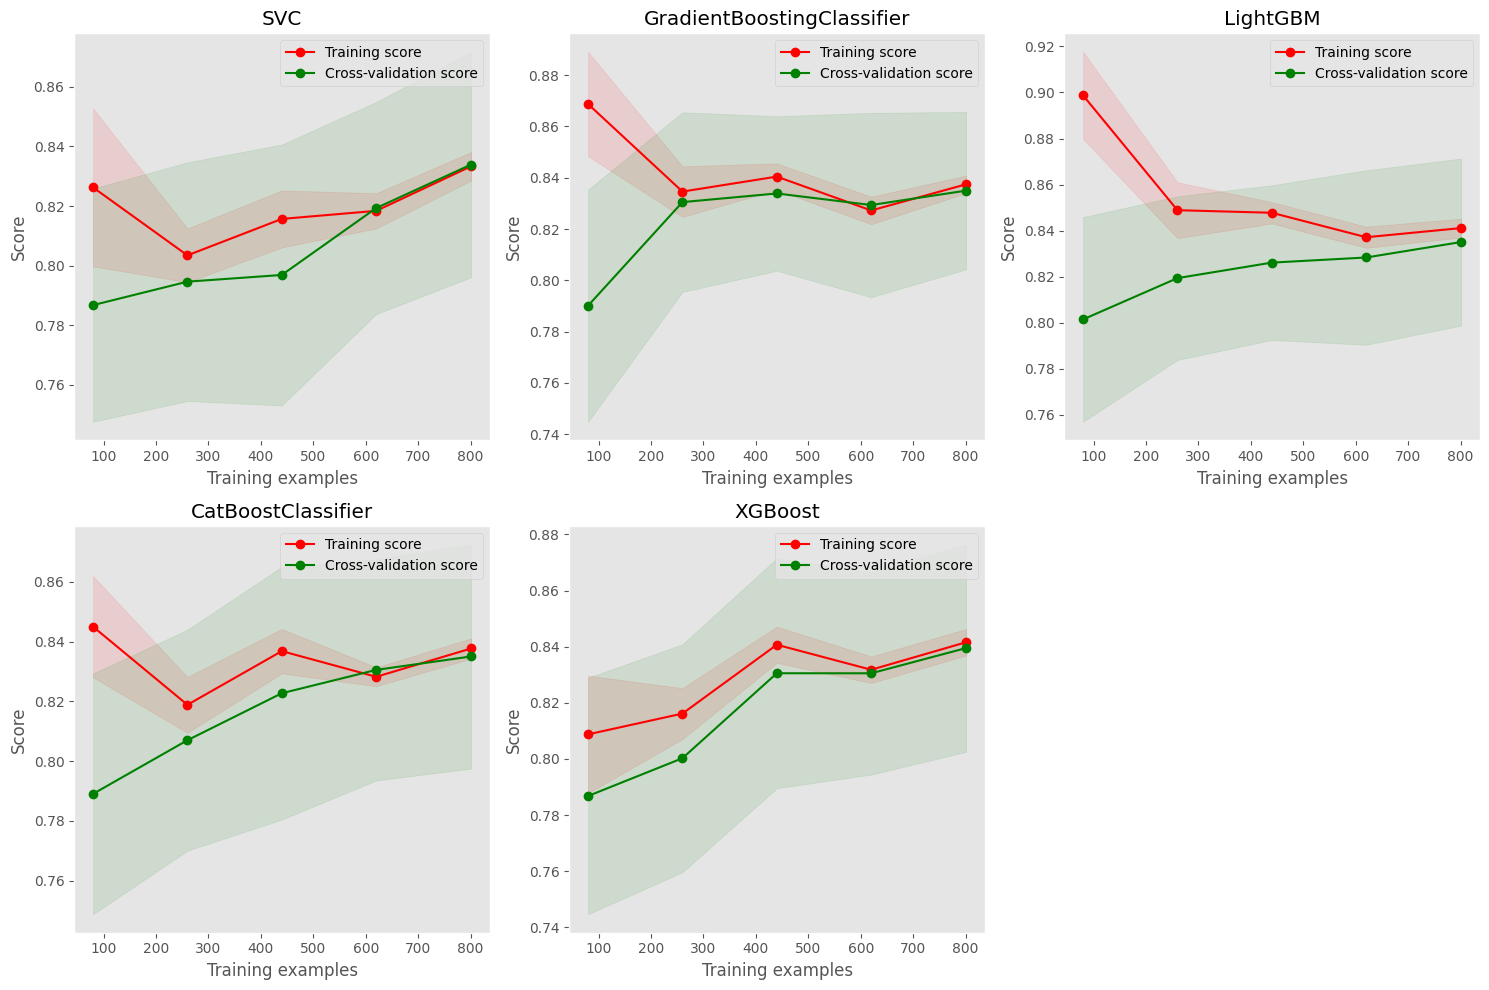

In [27]:
nrows = 2
ncols = 3

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is not None:
        ax = axes
    else:
        ax = plt.gca()

    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_scaled, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, "o-", color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, "o-", color="g",
             label="Cross-validation score")

    ax.legend(loc="best")
    return plt

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

estimators = [
    ("SVC", svc_gs.best_estimator_),
    ("GradientBoostingClassifier", gbc_gs.best_estimator_),
    ("LightGBM", lgbm_gs.best_estimator_),
    ("CatBoostClassifier", cbc_gs.best_estimator_),
    ("XGBoost", xgb_gs.best_estimator_)
]

for idx, (title, estimator) in enumerate(estimators):
    row = idx // ncols
    col = idx % ncols
    plot_learning_curve(estimator, title, X_scaled, y, axes=axes[row, col], cv=k_fold)

# Remove empty subplots
if len(estimators) < nrows * ncols:
    for idx in range(len(estimators), nrows * ncols):
        fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()

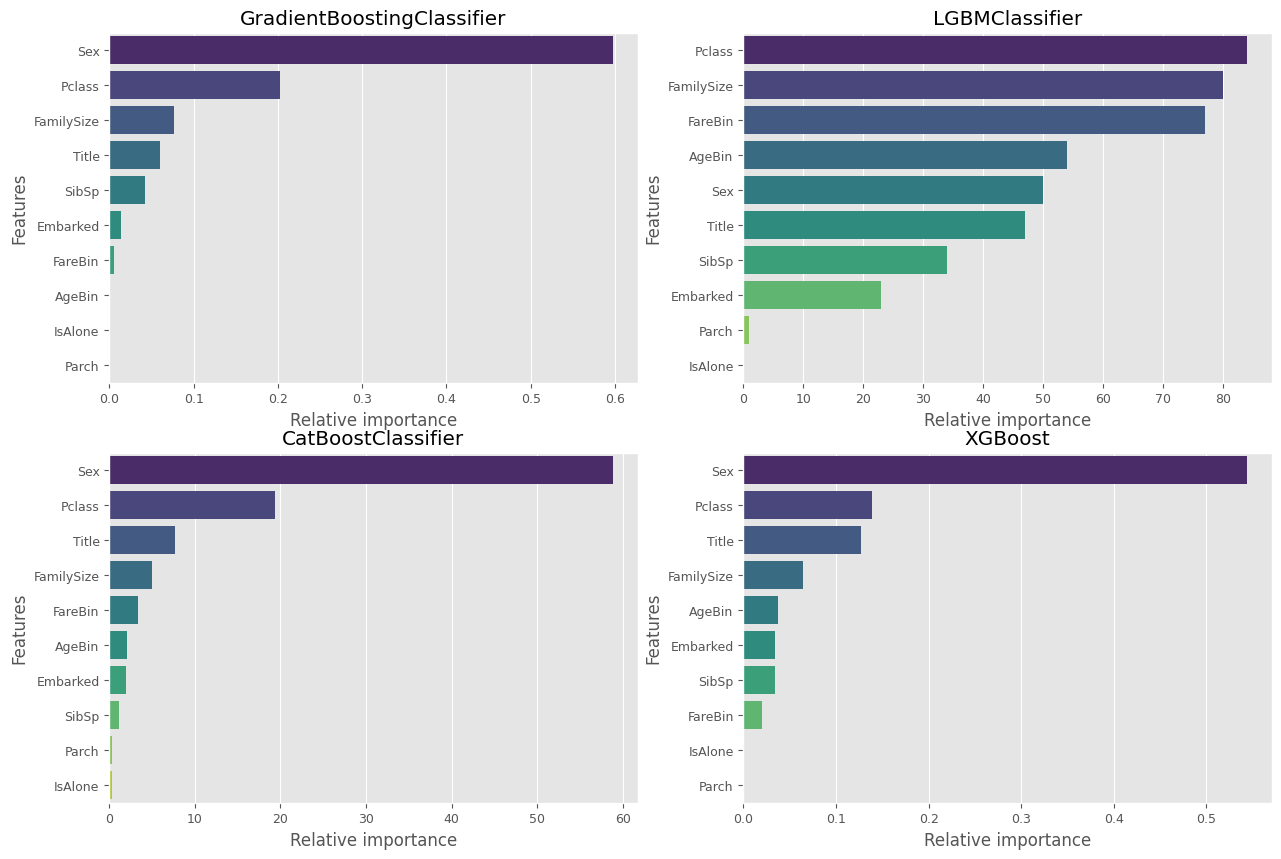

In [28]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(15,10))

names_classifiers = [
    ("GradientBoostingClassifier", best_gbc_model),
    ("LGBMClassifier", best_lgbm_model),
    ("CatBoostClassifier", best_cbc_model),
    ("XGBoost", best_xgb_model)
]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient="h",ax=axes[row][col], palette="viridis")
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name)
        nclassifier += 1

# Combining Best Models Into An Ensemble

In [29]:
vc = ensemble.VotingClassifier(
    estimators=[
        ("SVC", best_svc_model),
        ("GradientBoostingClassifier", best_gbc_model),
        ("LGBMClassifier", best_lgbm_model),
        ("CatBoostClassifier", best_cbc_model),
        ("XGBoost", best_xgb_model)
    ],
    voting="soft",
    n_jobs=-1
)

vc = vc.fit(X_scaled, y)

In [30]:
predictions = vc.predict(test_data)

submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": predictions
})

submission.to_csv("submission.csv", index=False)